In [2]:
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf
from tensorflow.keras import utils
import pandas as pd

#plot parameters that I personally like, feel free to make these your own.
import matplotlib
import matplotlib.patheffects as path_effects


#outlines for text 
pe1 = [path_effects.withStroke(linewidth=1.5,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
                             foreground="w")]

matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'


import sys
sys.path.insert(1, '/projects/reba1583/Research3/WAF_ML_Tutorial_Part2/scripts/')
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod
from gewitter_functions import get_acc

2024-02-29 09:46:48.847430: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
ds_train = xr.open_dataset('/rc_scratch/reba1583/CNN_data_multiAR/train.nc').isel(time = slice(0,1500))

ds_val = xr.open_dataset('/rc_scratch/reba1583/CNN_data_multiAR/validate.nc')

NameError: name 'xr' is not defined

In [3]:
train_random_shuffle = np.arange(len(ds_train.features))
np.random.shuffle(train_random_shuffle )

X_train = ds_train.features.values[train_random_shuffle]
Y_train = ds_train.labels_1d.values[train_random_shuffle]
time_train = ds_train.time[train_random_shuffle]

val_random_shuffle = np.arange(len(ds_val.features))
np.random.shuffle(val_random_shuffle)
X_val = ds_val.features.values[val_random_shuffle]
Y_val = ds_val.labels_1d.values[val_random_shuffle]
time_val = ds_val.time[val_random_shuffle]

In [4]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_data = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

2023-11-13 10:24:43.801746: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
#batch both 
batch_size = 64
train_data = train_data.batch(batch_size)
val_data = val_data.batch(batch_size)

In [6]:
for batch in train_data:
    break 
for batch in val_data:
    break 

2023-11-13 10:24:51.054979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [1500,11]
	 [[{{node Placeholder/_1}}]]
2023-11-13 10:24:51.220178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [1875,11]
	 [[{{node Placeholder/_1}}]]


<tf.Tensor: shape=(11,), dtype=float64, numpy=array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])>

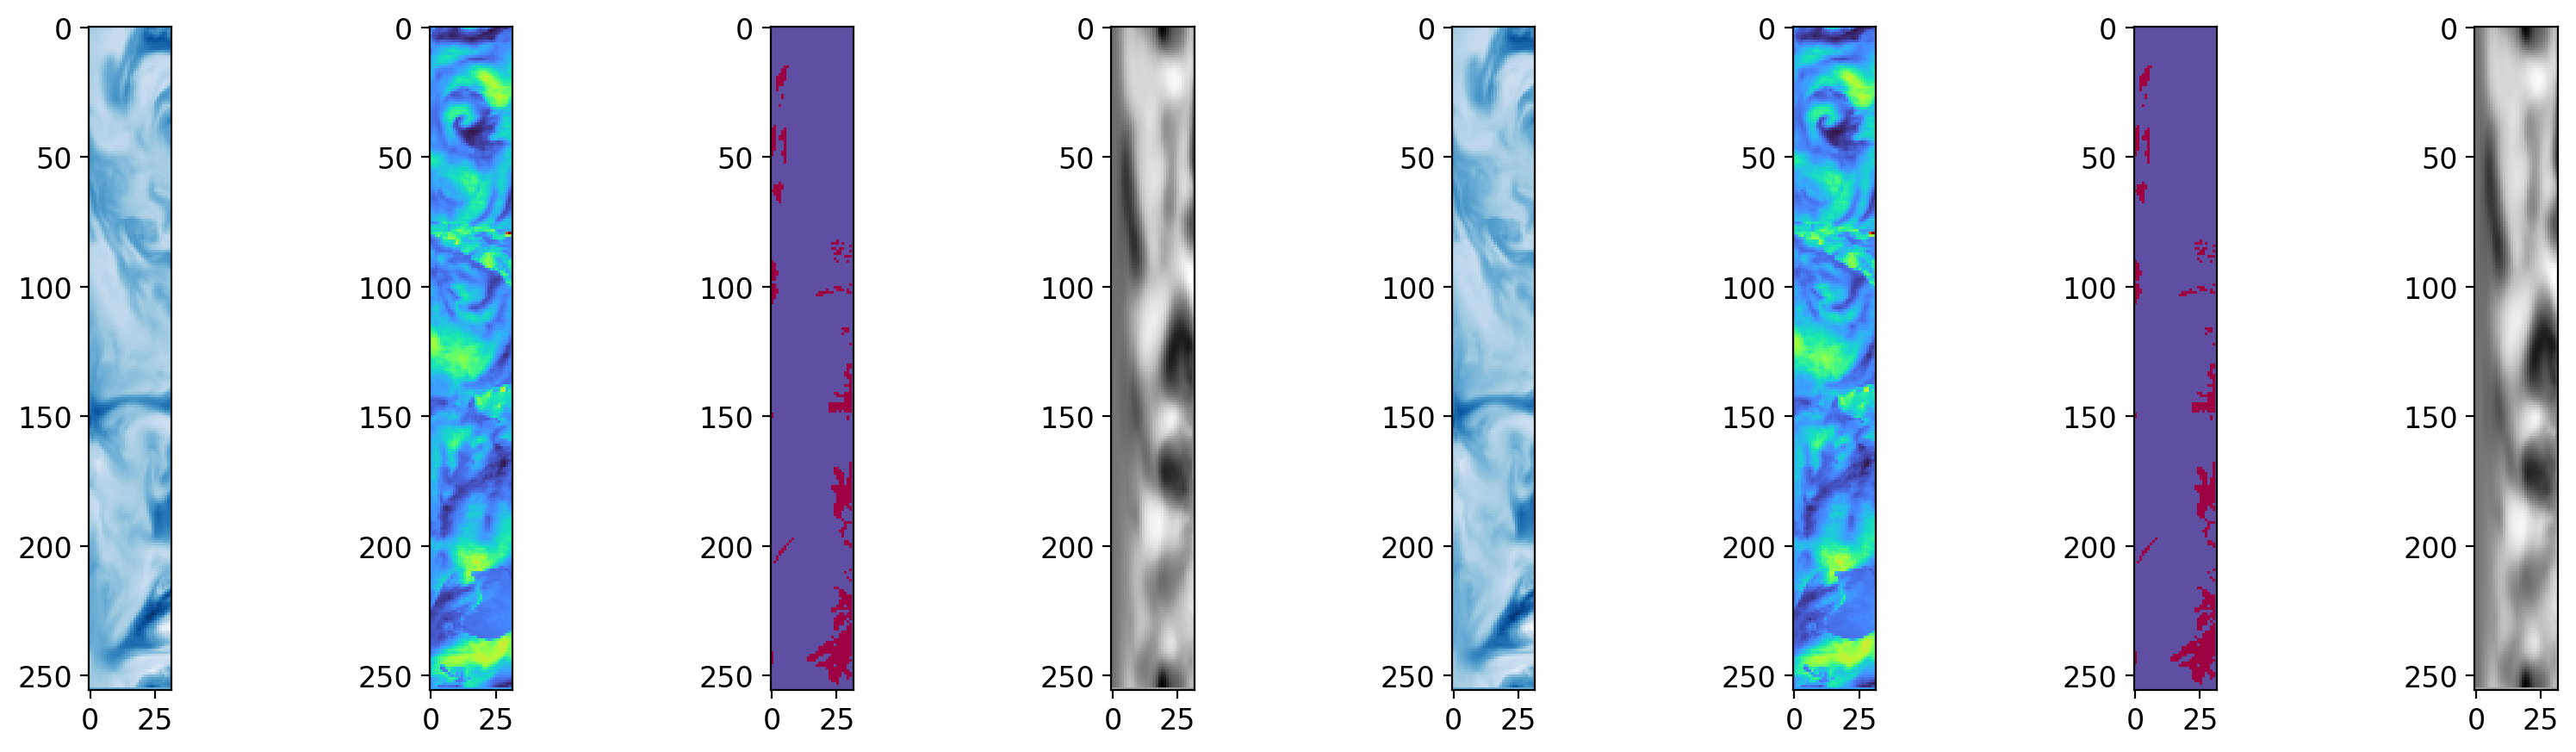

In [7]:
#get the features for example 12 in this batch 
one_example_features = batch[0][5]
#get the label for that same example 
one_example_label = batch[1][5]


fig,axes = plt.subplots(1,8,figsize=(20,5))
axes[0].imshow(one_example_features[:,:,0],cmap='Blues')
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[3].imshow(one_example_features[:,:,3],cmap='Greys_r')
axes[4].imshow(one_example_features[:,:,0],cmap='Blues')
axes[5].imshow(one_example_features[:,:,1],cmap='turbo')
axes[6].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[7].imshow(one_example_features[:,:,3],cmap='Greys_r')

one_example_label

In [8]:
model = tf.keras.models.Sequential([
        #input layer 
        tf.keras.layers.Conv2D(10,kernel_size=5,activation='relu',input_shape=(train_data.element_spec[0].shape[1:]),),

    
        #need to flatten/ravel the 2d image into a 1d vector 
         tf.keras.layers.GlobalAveragePooling2D(),
    
        #add two dense layers (which is the same as an ANN)
        tf.keras.layers.Dense(16,activation='relu'),
        tf.keras.layers.Dropout(0.33),
        tf.keras.layers.Dense(32,activation='relu'),
        tf.keras.layers.Dropout(0.33),
        
        #output layer 
        tf.keras.layers.Dense(11,activation='sigmoid')
        ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 28, 10)       2010      
                                                                 
 global_average_pooling2d (G  (None, 10)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                176       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [173]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(train_data.element_spec[0].shape[1:])),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(train_data.element_spec[0].shape[1:])),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.01),

    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.01),

    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Add max pooling layer
    

    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.01),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.01),

    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Add max pooling layer
    
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.01),
    
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.01),

    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Add max pooling layer

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(128, activation='relu'),  # Add dense layer
    tf.keras.layers.Dropout(0.5),  # Add dropout layer
    tf.keras.layers.Dense(64, activation='relu'),  # Add dense layer
    tf.keras.layers.Dropout(0.5),  # Add dropout layer
    tf.keras.layers.Dense(32, activation='relu'),
     tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16,a ctivation='relu'),

    #output layer 
    tf.keras.layers.Dense(11,activation='softmax'),
])


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 28, 10)       2010      
                                                                 
 global_average_pooling2d (G  (None, 10)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                176       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [9]:

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), metrics=['accuracy'])

history = model.fit(train_data,validation_data=val_data,epochs=10)




Epoch 1/10
24/24 [==============================] - 5s 136ms/step - loss: 3.9728 - accuracy: 0.0813 - val_loss: 4.0018 - val_accuracy: 0.0459
Epoch 2/10
24/24 [==============================] - 3s 122ms/step - loss: 3.9661 - accuracy: 0.0887 - val_loss: 4.0111 - val_accuracy: 0.0443
Epoch 3/10
24/24 [==============================] - 3s 143ms/step - loss: 4.0030 - accuracy: 0.0980 - val_loss: 4.0322 - val_accuracy: 0.0459
Epoch 4/10
24/24 [==============================] - 3s 120ms/step - loss: 4.1469 - accuracy: 0.0907 - val_loss: 4.0600 - val_accuracy: 0.0640
Epoch 5/10
24/24 [==============================] - 3s 114ms/step - loss: 4.4466 - accuracy: 0.1153 - val_loss: 4.0881 - val_accuracy: 0.0747
Epoch 6/10
24/24 [==============================] - 3s 114ms/step - loss: 5.0306 - accuracy: 0.1113 - val_loss: 4.1051 - val_accuracy: 0.0965
Epoch 7/10
24/24 [==============================] - 3s 109ms/step - loss: 5.9905 - accuracy: 0.1060 - val_loss: 4.1508 - val_accuracy: 0.1035
Epoch 

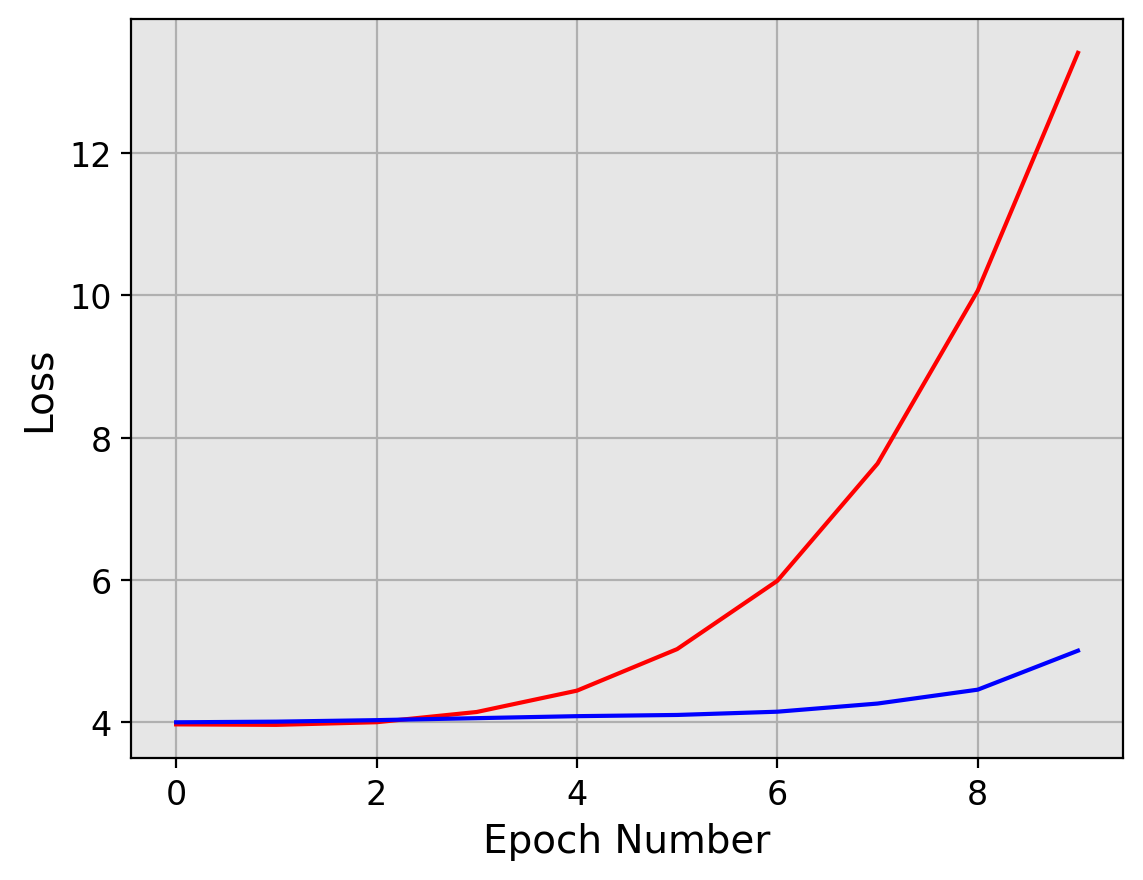

In [10]:
plt.plot(history.history['loss'],'-r')
plt.plot(history.history['val_loss'],'-b')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid()

In [11]:
y_preds_distribution = model.predict(val_data)

30/30 [==============================] - 1s 33ms/step


In [13]:
np.shape(y_preds_distribution)

(1875, 11)

In [25]:
val_pd = pd.DataFrame(Y_val)
val_pd = val_pd.set_index(np.array(time_val))
val_pd

,0,1,2,3,4,5,6,7,8,9,10
2008-10-09 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1990-10-10 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2013-01-29 18:00:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1982-11-08 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2008-04-27 06:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2006-01-27 00:00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1980-09-30 06:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-04-22 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1996-12-24 18:00:00,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
results_pd = pd.DataFrame(y_preds_distribution)
results_pd = results_pd.set_index(np.array(time_val))
results_pd

,0,1,2,3,4,5,6,7,8,9,10
2008-10-09 06:00:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1990-10-10 18:00:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2013-01-29 18:00:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1982-11-08 00:00:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2008-04-27 06:00:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2006-01-27 00:00:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1980-09-30 06:00:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014-04-22 12:00:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1996-12-24 18:00:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [23]:
len(np.array(time_val))

1875

## Figure out some better ways to looks at outcome

In [26]:
#the contingency table calculator expects y_true,y_pred
cont_table = get_contingency_table(Y_val,y_preds)

accuracy = get_acc(cont_table)
print('Accuracy = {}%'.format(np.round(accuracy,0)))

Accuracy = 25.0%


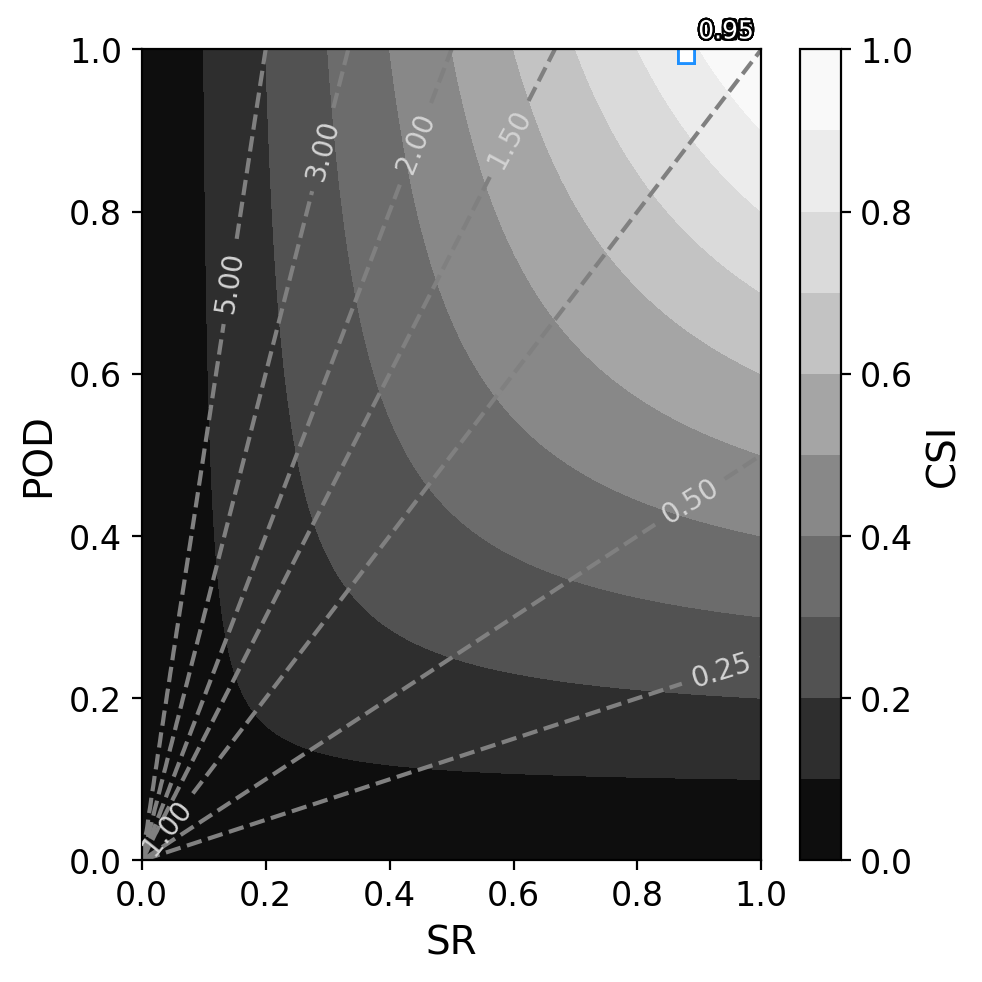

In [27]:
#import some helper functions for our other directory.
#probability threholds 
thresh = np.arange(0.05,1.05,0.05)

#statsitcs we need for performance diagram 
tp = tf.keras.metrics.TruePositives(thresholds=thresh.tolist())
fp = tf.keras.metrics.FalsePositives(thresholds=thresh.tolist())
fn = tf.keras.metrics.FalseNegatives(thresholds=thresh.tolist())

#get performance diagram line by getting tp,fp and fn 
tp.reset_state()
fp.reset_state()
fn.reset_state()

tps = tp(Y_val,y_preds)
fps = fp(Y_val,y_preds)
fns = fn(Y_val,y_preds)

#calc x,y of performance diagram 
pods = tps/(tps + fns)
srs = tps/(tps + fps)
csis = tps/(tps + fns + fps)

#import some helper functions for our other directory.
import sys
sys.path.insert(1, '../scripts/')

#load contingency_table func

#plot it up  
ax = make_performance_diagram_axis()
ax.plot(np.asarray(srs),np.asarray(pods),'-s',color='dodgerblue',markerfacecolor='w',label='UNET')

for i,t in enumerate(thresh):
    if np.mod(i,3)==0:
        text = np.char.ljust(str(np.round(t,2)),width=4,fillchar='0')
        ax.text(np.asarray(srs)[i]+0.02,np.asarray(pods)[i]+0.02,text,path_effects=pe1,fontsize=9,color='white')

plt.tight_layout()

In [28]:
#grab layer 1 weights, which are the convolution filters. 
filters = model.weights[0]

filters.shape

TensorShape([5, 5, 8, 10])

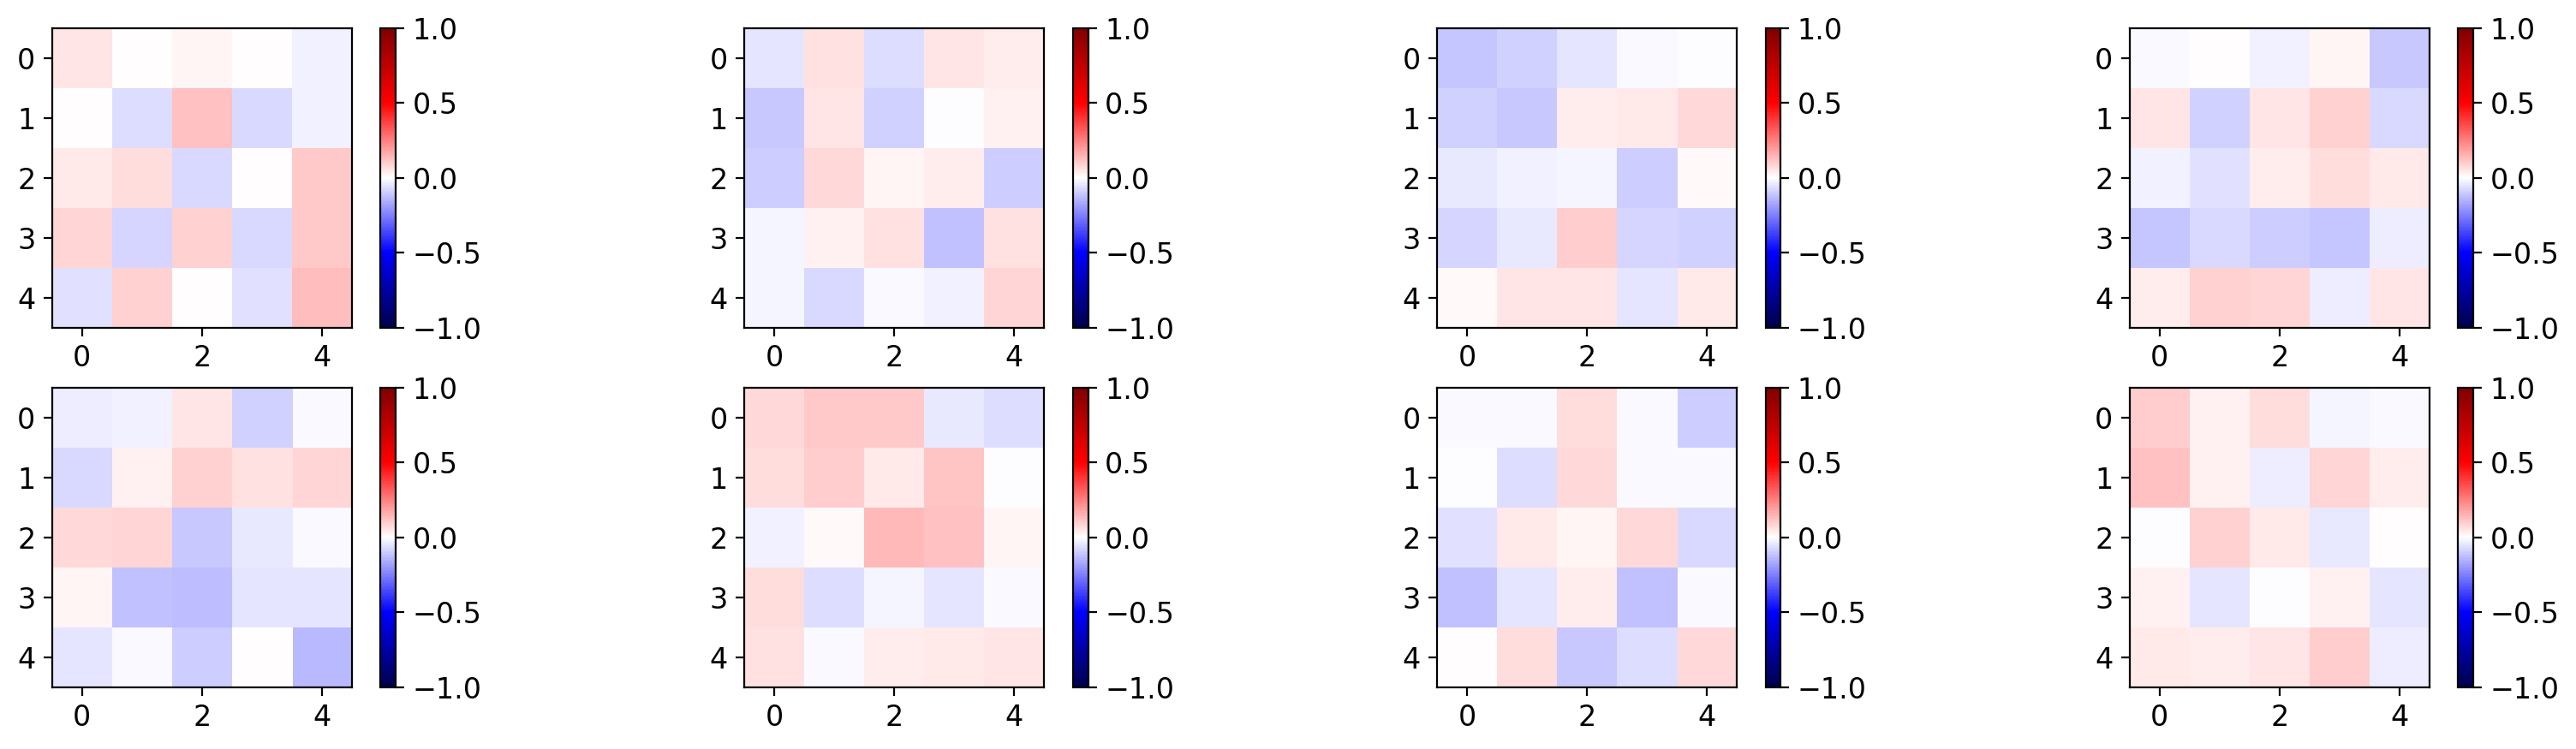

In [29]:
fig,axes = plt.subplots(2,4,figsize=(20,5))
axes = axes.flatten()
for i in np.arange(0,8):
    pm = axes[i].imshow(filters[:,:,i,0],vmin=-1,vmax=1,cmap='seismic')
    plt.colorbar(pm,ax=axes[i])
    

In [30]:
## Checkout certain layer 
for l,layer in enumerate(model.layers):
    print(l,layer.name)

0 conv2d
1 global_average_pooling2d
2 dense
3 dropout
4 dense_1
5 dropout_1
6 dense_2


In [189]:
#identify the convolutional layer
conv_layer = model.get_layer('dense_35')

#re-wire a model to take the normal model inputs, but now just output the result of the convolution
conv_output = tf.keras.models.Model([model.inputs], [conv_layer.output])

#run the model the same way, to see what the output convovled image
convolved_images = conv_output.predict(val_data)

#grab a batch to look at 
for batch in val_data:
    break 

55/55 [==============================] - 10s 185ms/step


In [190]:
np.shape(convolved_images)

(1733, 32)

In [191]:
convolved_images[0]

array([0.08136991, 0.46429023, 0.        , 0.        , 0.09610785,
       0.        , 0.22643623, 0.        , 0.        , 0.05595372,
       0.        , 0.        , 0.        , 0.0551133 , 0.        ,
       0.        , 0.        , 0.        , 0.2178149 , 0.        ,
       0.26626998, 0.16072938, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.10854318], dtype=float32)

In [136]:
np.shape(convolved_images)

(1733, 64, 8, 20)

In [130]:
convolved_images = convolved_images[:,:,:,-1]

In [131]:
n = 0

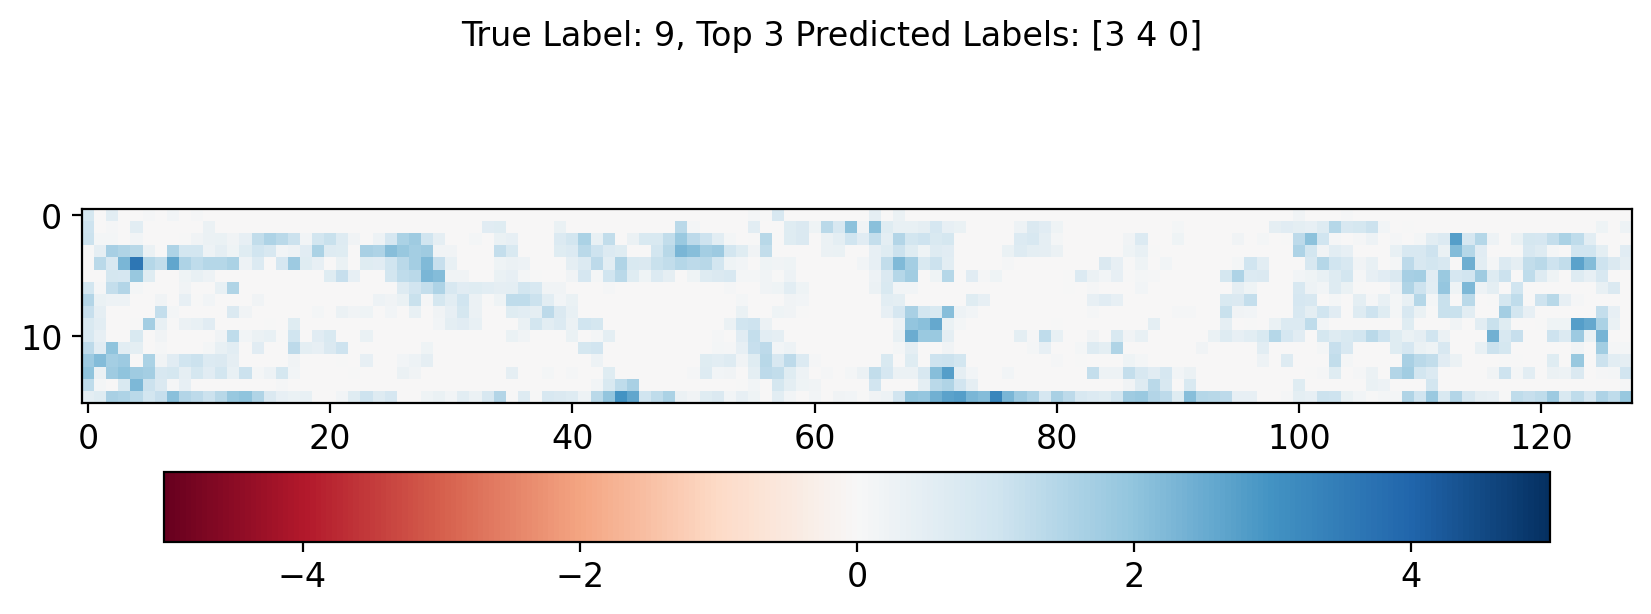

In [132]:
fig,axes = plt.subplots(1,1,figsize=(10,3))
fig.suptitle('True Label: '+str(int(np.argwhere(one_example_label.numpy()==1)))+', Top 3 Predicted Labels: '+str(np.flip(np.argsort(y_preds_distribution[n]))[0:3]) )
t=axes.imshow(convolved_images[n].T, vmin = -5, vmax = 5,cmap='RdBu')
fig.colorbar(t, orientation = 'horizontal')


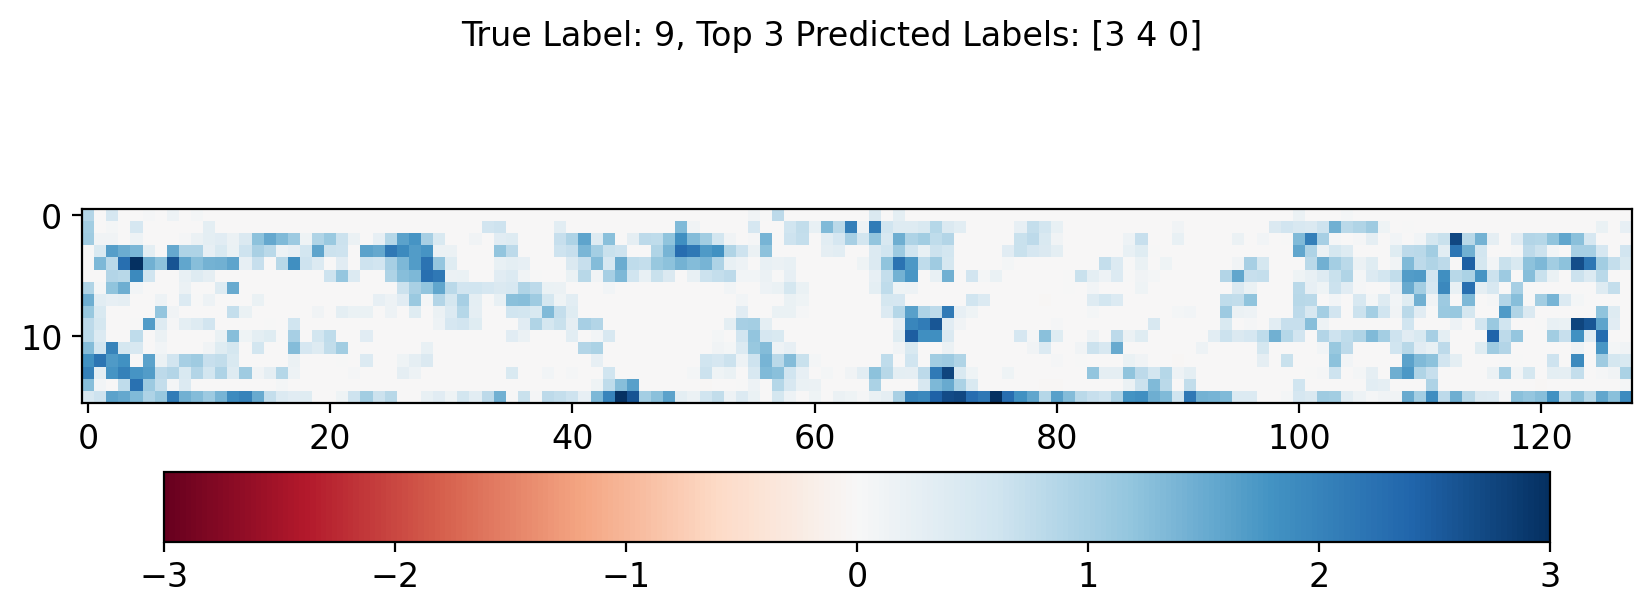

In [120]:
fig,axes = plt.subplots(1,1,figsize=(10,3))
fig.suptitle('True Label: '+str(int(np.argwhere(one_example_label.numpy()==1)))+', Top 3 Predicted Labels: '+str(np.flip(np.argsort(y_preds_distribution[n]))[0:3]) )
t=axes.imshow(convolved_images[n].T, vmin = -3, vmax = 3,cmap='RdBu')
fig.colorbar(t, orientation = 'horizontal')


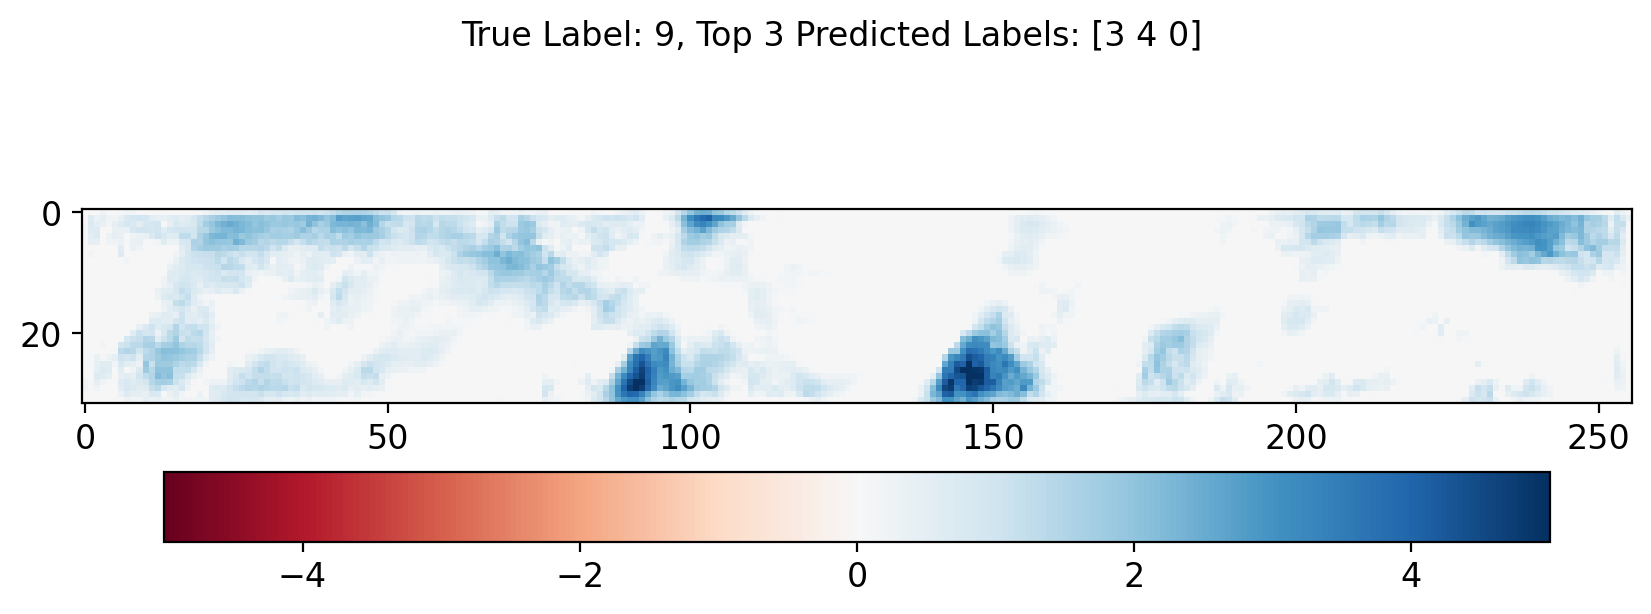

In [101]:
fig,axes = plt.subplots(1,1,figsize=(10,3))
fig.suptitle('True Label: '+str(int(np.argwhere(one_example_label.numpy()==1)))+', Top 3 Predicted Labels: '+str(np.flip(np.argsort(y_preds_distribution[n]))[0:3]) )
t=axes.imshow(convolved_images[n].T, vmin = -5, vmax = 5,cmap='RdBu')
fig.colorbar(t, orientation = 'horizontal')


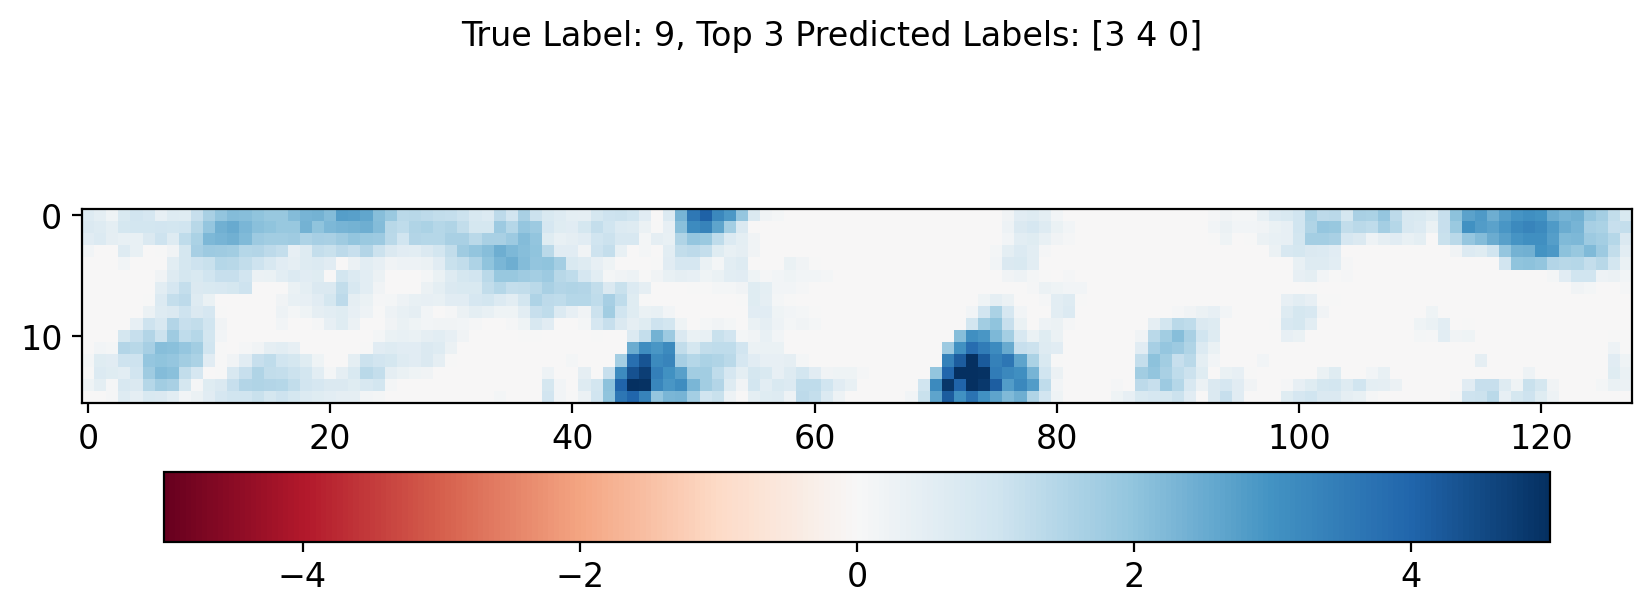

In [106]:
fig,axes = plt.subplots(1,1,figsize=(10,3))
fig.suptitle('True Label: '+str(int(np.argwhere(one_example_label.numpy()==1)))+', Top 3 Predicted Labels: '+str(np.flip(np.argsort(y_preds_distribution[n]))[0:3]) )
t=axes.imshow(convolved_images[n].T, vmin = -5, vmax = 5,cmap='RdBu')
fig.colorbar(t, orientation = 'horizontal')

Text(0, 0.5, 'Predicted Likelihood')

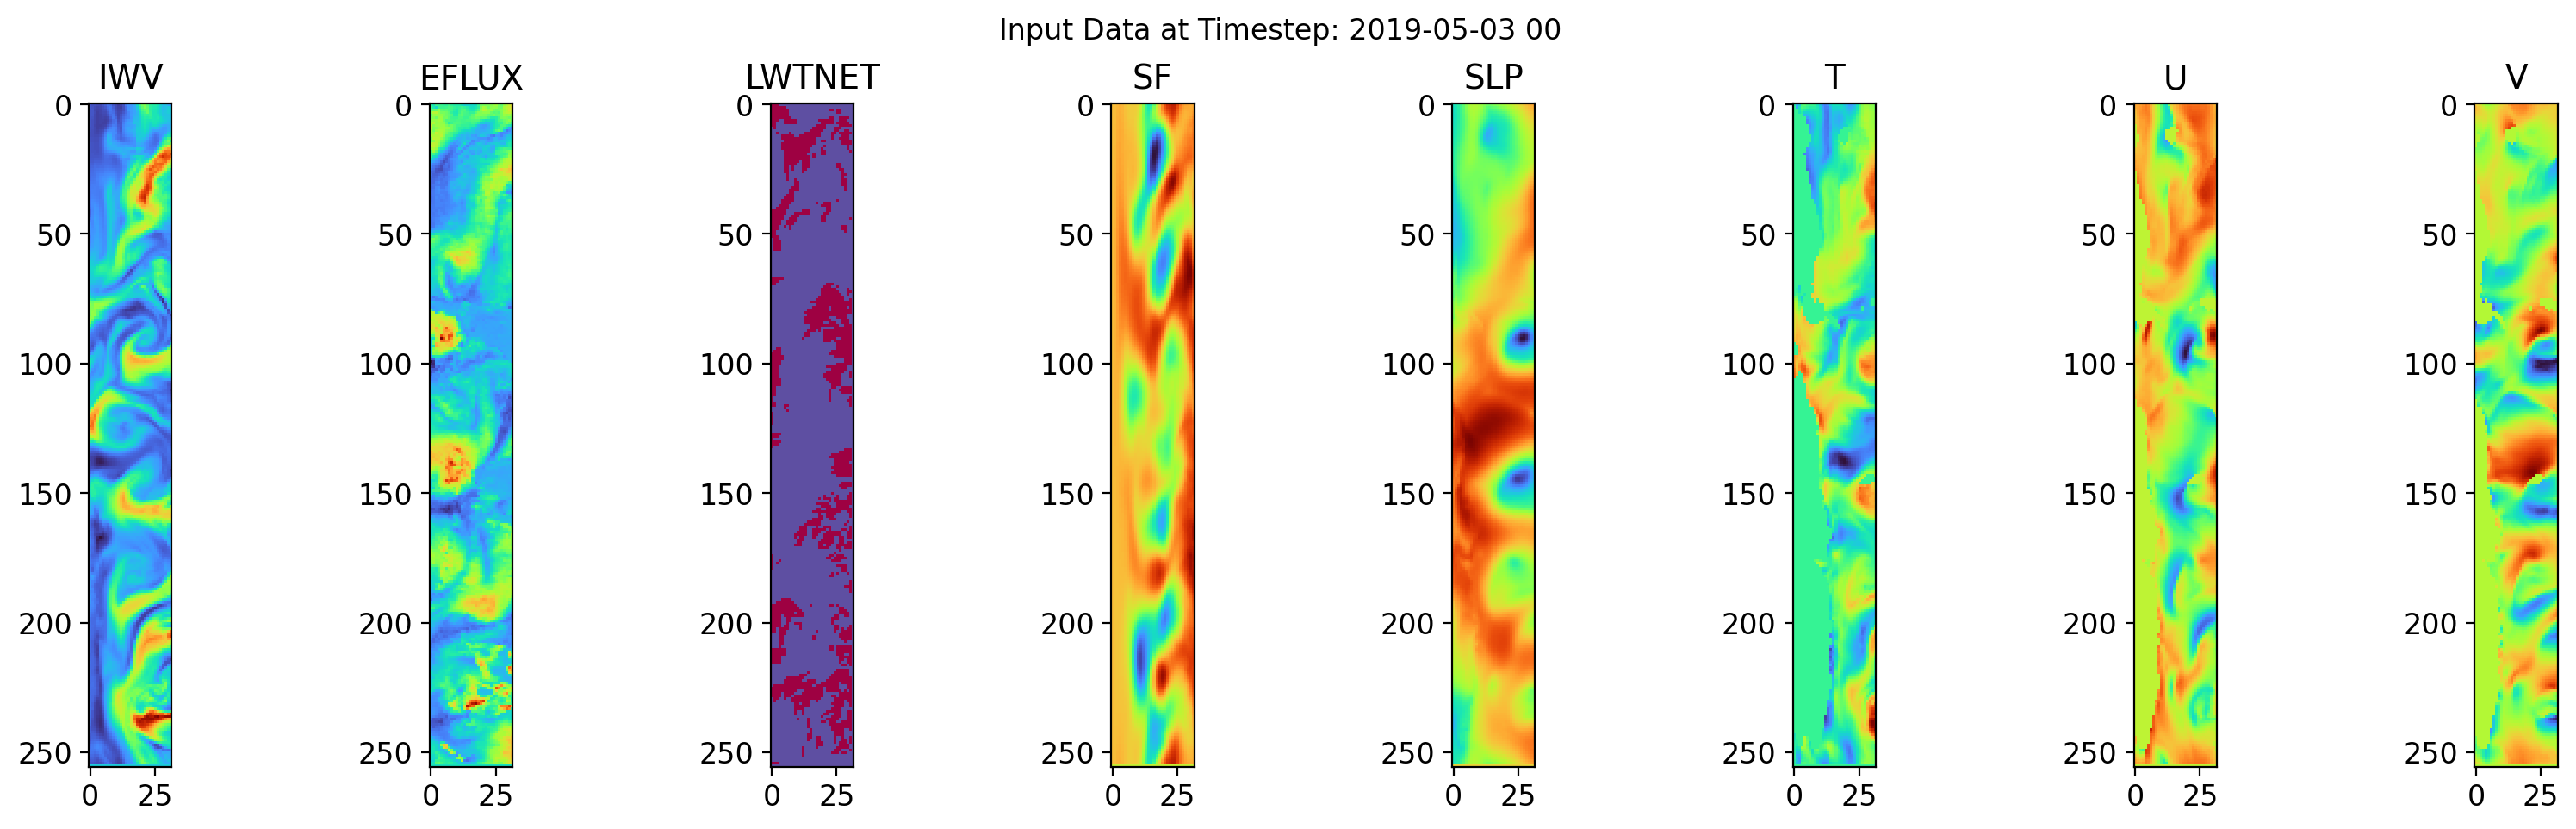

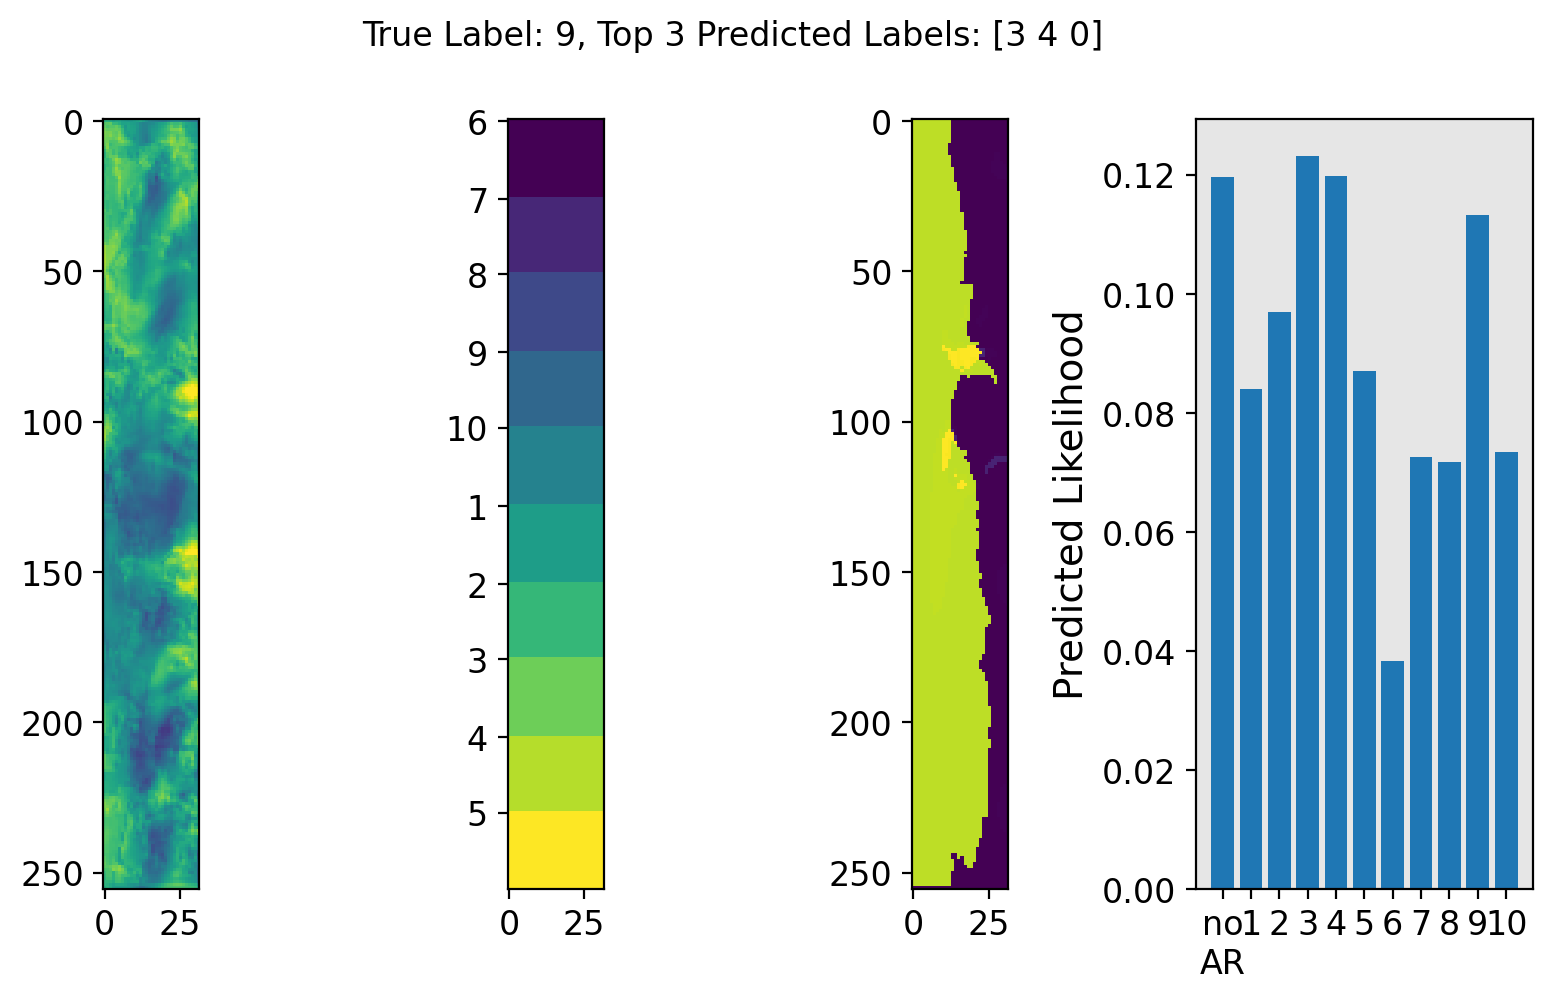

In [75]:
Y_visual_data = xr.open_dataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Y_labels_AR_PRECSN_T/'+str(pd.to_datetime(time_val[n].values).year))
Y_visual_data = Y_visual_data.sel(time = time_val[n].values).Y.values.T

# Make category visual
lons = np.shape(batch[0])[1]
start = np.round(np.arange(0,lons,lons/10))
end = np.round(np.arange(lons/10,lons+lons/10, lons/10))
show_categories = np.zeros((np.shape(batch[0])[0:2][1],np.shape(batch[0])[0:2][0]))
for c in range(10):
    show_categories[int(start[c]):int(end[c]),:] = c+1

#get the features for example 12 in this batch 
one_example_features = batch[0][n]
#get the label for that same example 
one_example_label = batch[1][n]

titles = ['IWV', 'EFLUX', 'LWTNET', 'SF', 'SLP', 'T', 'U', 'V']

fig,axes = plt.subplots(1,8,figsize=(20,5))
fig.suptitle('Input Data at Timestep: '+str(pd.to_datetime(time_val[n].values))[0:13])
axes = axes.flatten()
axes[0].imshow(one_example_features[:,:,0],cmap='turbo')
axes[0].set_title(titles[0])
axes[1].imshow(one_example_features[:,:,1],cmap='turbo')
axes[1].set_title(titles[1])
axes[2].imshow(one_example_features[:,:,2],cmap='Spectral_r')
axes[2].set_title(titles[2])
axes[3].imshow(one_example_features[:,:,3],cmap='turbo')
axes[3].set_title(titles[3])
axes[4].imshow(one_example_features[:,:,4],cmap='turbo')
axes[4].set_title(titles[4])
axes[5].imshow(one_example_features[:,:,5],cmap='turbo')
axes[5].set_title(titles[5])
axes[6].imshow(one_example_features[:,:,6],cmap='turbo')
axes[6].set_title(titles[6])
axes[7].imshow(one_example_features[:,:,7],cmap='turbo')
axes[7].set_title(titles[7])



fig,axes = plt.subplots(1,4,figsize=(10,5))
fig.suptitle('True Label: '+str(int(np.argwhere(one_example_label.numpy()==1)))+', Top 3 Predicted Labels: '+str(np.flip(np.argsort(y_preds_distribution[n]))[0:3]) )
axes = axes.flatten()
axes[0].imshow(convolved_images[n], vmin = -3, vmax = 3)
axes[1].imshow(show_categories)
axes[1].set_yticks(np.round(np.arange(0,lons,lons/10)))
axes[1].set_yticklabels(['6','7','8','9','10','1','2','3','4','5',]);
axes[1].imshow(show_categories)
axes[2].imshow(Y_visual_data)

axes[3].bar(np.arange(0,11,1),y_preds_distribution[n])
axes[3].set_xticks(np.arange(0,11,1), ['no\nAR','1','2','3','4','5','6','7','8','9','10']);
axes[3].set_ylabel('Predicted Likelihood')